# More Theories and Models (Continue)

## Exponential Smoothing (ETS)

## Holt Winter’s Exponential Smoothing

## ARIMA

## Meta-Learning

## Reference

TODO: More on the R Forecast Liberary

# Using Deep Learning to Forecast

In [ ]:
import os
import sys
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
%matplotlib inline

# from common.utils import load_data, mape

print(sys.version)
import pandas as pd

## Time-Series Forecasting Using Deep Learning on GluonTS

### Background
Time series, as the name suggests, are collections of data points that are indexed by time. Time series arise naturally in many different applications, typically by measuring the value of some underlying process at a fixed time interval.

Given a set of time series, you might ask various kinds of questions:

 * How will the time series evolve in the future? **Forecasting**
 * Is the behavior of the time series in a given period abnormal? **Anomaly detection**
 * Which group does a given time series belong to? **Time series classification**
 * Some measurements are missing, what were their values? **Imputation**

### GluonTS Introduction
The GluonTS toolkit contains components and tools for building time series models using MXNet. The models that are currently included are forecasting models but the components also support other time series use cases, such as classification or anomaly detection.

GluonTS contains:

* Components for building new models (likelihoods, feature processing pipelines, calendar features etc.)
* Data loading and processing
* A number of pre-built models
* Plotting and evaluation facilities
* Artificial and real datasets (only external datasets with blessed license)


### Probabilistic Forecasting
GluonTS gives focus (but is not restricted) to probabilistic forecasting, i.e., forecasting the future distribution of the values and not the future values themselves (point estimates) of a time series. Having estimated the future distribution of each time step in the forecasting horizon, we can draw a sample from the distribution at each time step and thus create a “sample path” that can be seen as a possible realization of the future. In practice we draw multiple samples and create multiple sample paths which can be used for visualization, evaluation of the model, to derive statistics, etc.

### Prepare the Dataset

In [276]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
import pandas as pd
import matplotlib.pyplot as plt
import json

In [3]:
# Load the Walmart sales dataset
ts = pd.read_csv('../data/sales_weekly.csv', index_col='ds')

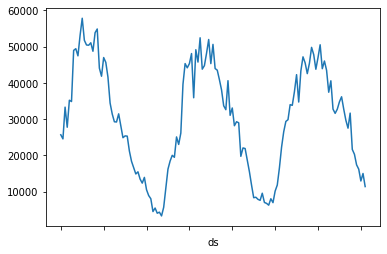

In [257]:
# Explore individual store/SKU performance
ts['10_16'].plot()

In [161]:
# Calculate the correlation to find highly correlated store/SKU time series
corr_mat = ts.corr()

In [258]:
corr_mat.sort_values(by=['10_16'], ascending=False).head(50)

,10_1,10_10,10_11,10_12,10_13,10_14,10_16,10_17,10_18,10_19,...,9_9,9_90,9_91,9_92,9_93,9_94,9_95,9_96,9_97,9_98
10_16,-0.243487,0.311280,0.104078,0.642497,0.117482,-0.400868,1.000000,-0.258267,-0.578346,-0.200772,...,0.142500,-0.098908,0.329604,-0.367008,0.117913,0.163053,0.424643,0.130751,-0.002160,-0.350688
6_16,-0.143666,0.301861,0.129751,0.618689,0.050032,-0.344044,0.940375,-0.237238,-0.483437,-0.186005,...,0.186703,-0.069819,0.316520,-0.337167,0.167749,0.076188,0.384845,0.161603,-0.110299,-0.293155
12_16,-0.268143,0.316904,0.162378,0.641298,0.024418,-0.412501,0.929291,-0.320888,-0.536320,-0.238858,...,0.198306,-0.069739,0.454605,-0.325736,0.138460,0.120519,0.467451,0.260515,-0.085502,-0.296932
11_16,-0.146384,0.300771,0.109719,0.625657,0.074522,-0.341485,0.918867,-0.239083,-0.471722,-0.157058,...,0.240519,-0.086017,0.318993,-0.347298,0.141452,0.057796,0.363535,0.161275,-0.102572,-0.293144
28_16,-0.234142,0.283242,0.166387,0.643486,0.113733,-0.349092,0.916634,-0.254150,-0.500212,-0.162885,...,0.160898,-0.171813,0.365872,-0.419570,0.140862,0.132398,0.337169,0.194378,0.002336,-0.287781
2_16,-0.184007,0.269698,0.216801,0.583970,0.008807,-0.335350,0.916178,-0.275567,-0.447626,-0.201175,...,0.217637,-0.090249,0.400568,-0.351229,0.091263,0.098920,0.408647,0.261683,-0.145873,-0.262977
4_16,-0.196136,0.294835,0.228472,0.570089,-0.043468,-0.377535,0.912296,-0.328176,-0.464284,-0.220476,...,0.218585,-0.056537,0.475083,-0.329598,0.082989,0.102230,0.474572,0.307690,-0.141139,-0.268413
34_16,-0.156345,0.237092,0.171286,0.573857,-0.013236,-0.351274,0.911314,-0.300110,-0.438193,-0.162811,...,0.195008,-0.108175,0.350624,-0.369354,0.105517,0.101571,0.364235,0.206265,-0.136557,-0.257443
1_16,-0.092200,0.246983,0.107434,0.575666,0.032491,-0.315904,0.908373,-0.230649,-0.421568,-0.157285,...,0.241157,-0.052473,0.275599,-0.318307,0.119747,0.121882,0.355038,0.137703,-0.126874,-0.271882
39_16,-0.088557,0.258350,0.044938,0.573227,0.046368,-0.300536,0.900772,-0.211280,-0.430249,-0.131433,...,0.213483,-0.022361,0.231758,-0.290852,0.165935,0.111220,0.328180,0.078932,-0.114244,-0.263639


In [ ]:
# Select a subset of time series for forecasting exercise
ts_select = ts.loc[:,corr_mat.sort_values(by=['10_16'], ascending=False).head(100).index]

In [ ]:
# Convert the data into GluonTS-compatible format
start = pd.Timestamp("02-05-2010", freq='W-FRI')
train_ds = [{'target': ts[column].head(-39).values, 'start': start} for column in ts_select]
test_ds = [{'target': ts[column].values, 'start': start} for column in ts_select]

### Basic Neural Network Forecasting Model
GluonTS comes with a number of pre-built models that can be used directly with minor hyperparameter configurations.

In this example we will use a simple pre-built feedforward neural network estimator that takes as input a window of length `context_length` and predicts the distribution of the values of the subsequent future window of length `prediction_length`.

In [262]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

In [ ]:
train_data = train_ds
test_data = test_ds

In [289]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=39,
    context_length=52,
    freq='1W',
    trainer=Trainer(ctx="cpu", epochs=50, learning_rate=1E-3, hybridize=True, num_batches_per_epoch=200,),
)

After specifing our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` just by invoking the `train` method of the estimator. The training returns a predictor that can be used to predict.

In [290]:
predictor = estimator.train(train_data)

INFO:root:Start model training
INFO:root:Number of parameters in SimpleFeedForwardTrainingNetwork: 393
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 200/200 [00:00<00:00, 285.71it/s, avg_epoch_loss=10.1]
INFO:root:Epoch[0] Elapsed time 0.704 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.136981
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:00<00:00, 216.74it/s, avg_epoch_loss=9.72]
INFO:root:Epoch[1] Elapsed time 0.926 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.720421
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:00<00:00, 255.08it/s, avg_epoch_loss=9.67]
INFO:root:Epoch[2] Elapsed time 0.792 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=9.674368
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:00<00:00, 288.54it/s, avg_epoch_loss=9.61]
INFO:root:Epoch[3] Elapsed time 0.696 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=9.609713
INFO:root:Epoch[4] L

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=9.512392
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 200/200 [00:00<00:00, 271.19it/s, avg_epoch_loss=9.55]
INFO:root:Epoch[37] Elapsed time 0.742 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=9.547036
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 200/200 [00:00<00:00, 301.74it/s, avg_epoch_loss=9.53]
INFO:root:Epoch[38] Elapsed time 0.664 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=9.531345
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 200/200 [00:00<00:00, 267.30it/s, avg_epoch_loss=9.52]
INFO:root:Epoch[39] Elapsed time 0.750 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=9.519703
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 200/200 [00:00<00:00, 259.65it/s, avg_epoch_loss=9.52]
INFO:root:Epoch[40] Elapsed time 0.772 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=9.515662
INFO:root:Epoch[41] Learning rate is 0.001
100%|████

Now we have a predictor in our hands. We can use it to predict the last window of the `dataset.test` and evaluate how our model performs.

GluonTS comes with the `make_evaluation_predictions` function that automates all this procedure. Roughly, this module performs the following steps:

- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining dataset to predict (in the form of sample paths) the "future" window that was just removed 
- The module outputs a generator over the forecasted sample paths and a generator over the `dataset.test`

In [266]:
# Visualize the forecast results
from itertools import islice
from gluonts.evaluation.backtest import make_evaluation_predictions

In [291]:
# This function returns 
forecast_it, ts_it = make_evaluation_predictions(
    test_data, 
    predictor=predictor, 
    num_eval_samples=200)

#  Convert these generators to lists to ease the subsequent computations
forecasts = list(forecast_it)
tss = list(ts_it)

Now, let's see what do these lists contain under the hood. Let's start with the time series `tss` that is simpler. Each item in the `tss` list is just a pandas dataframe that contains the actual time series.

In [293]:
tss[0].head(5)  

,0
2010-02-07,25694.43
2010-02-14,24555.89
2010-02-21,33321.92
2010-02-28,27773.67
2010-03-07,35227.56


The `forecasts` list is a bit more complex. Each item in the `forecasts` list is an object that contains all the sample paths in the form of `numpy.ndarray` with dimension `(num_samples, prediction_length)`, the start date of the forecast, the frequency of the time series, etc. We can access all these information by simply invoking the corresponding attribute of the forecast object.

In [294]:
print(f"Number of sample paths: {forecasts[0].num_samples}")
print(f"Dimension of samples: {forecasts[0].samples.shape}")
print(f"Start date of the forecast window: {forecasts[0].start_date}")
print(f"Frequency of the time series: {forecasts[0].freq}")

Number of sample paths: 200
Dimension of samples: (200, 39)
Start date of the forecast window: 2012-02-03 00:00:00
Frequency of the time series: 1W


Apart from retrieving basic information we can do some more complex calculations such as to compute the mean or a given quantile of the values of the forecasted window.

In [295]:
print(f"Mean of the future window:\n {forecasts[0].mean}")
print(f"0.5-quantile (median) of the future window:\n {forecasts[0].quantile(0.5)}")

Mean of the future window:
 [20680.146 21511.69  25312.93  27974.223 28540.    36489.883 41060.13
 40571.094 44909.25  46470.86  45852.516 45183.453 44170.73  44553.93
 44035.26  43634.426 44777.137 43944.11  43486.766 42338.355 42133.87
 40158.977 39338.22  36375.566 34506.73  34192.2   34308.883 32875.92
 31681.87  27564.154 27059.39  26589.77  24936.477 22840.94  20649.314
 19453.414 18001.63  13642.23  11372.856]
0.5-quantile (median) of the future window:
 [20896.1   22643.83  25418.807 28672.654 29299.904 36213.98  40684.56
 40454.438 44606.97  47456.09  45739.44  46351.73  44402.668 44056.41
 44804.023 43504.086 44922.746 43934.746 42816.594 42425.81  41779.89
 40965.41  38953.53  37437.883 34993.414 34741.023 34804.09  33262.41
 31089.578 28137.316 27388.453 26703.084 24825.027 22571.342 21020.293
 19320.824 18350.361 13740.588 11476.989]


Finally, each forecast object has a `
plot` method that can be parametrized to show the mean, prediction intervals, etc. The prediction intervals are plotted in different shades so they are distinct.

In [272]:
def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

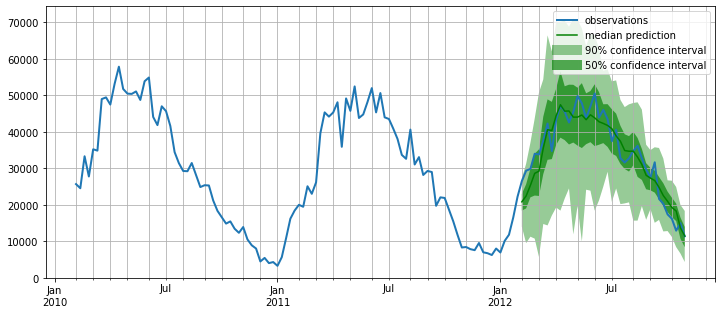

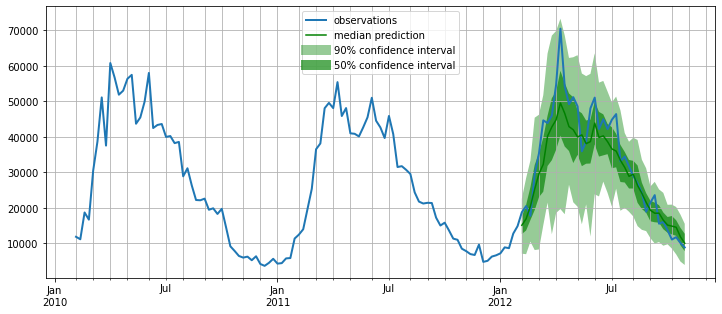

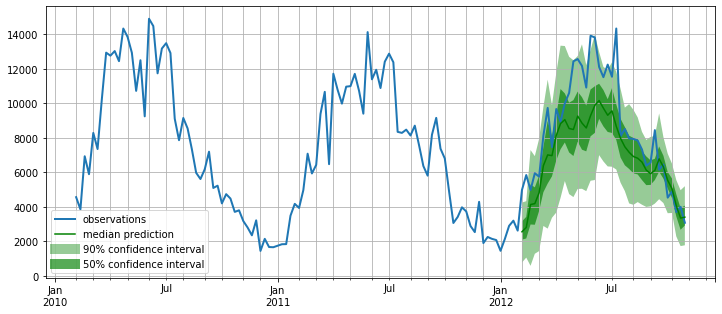

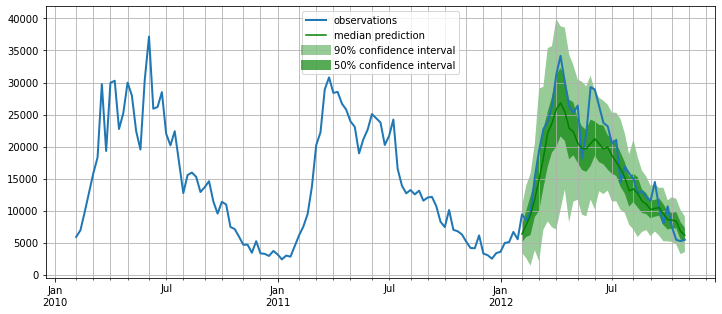

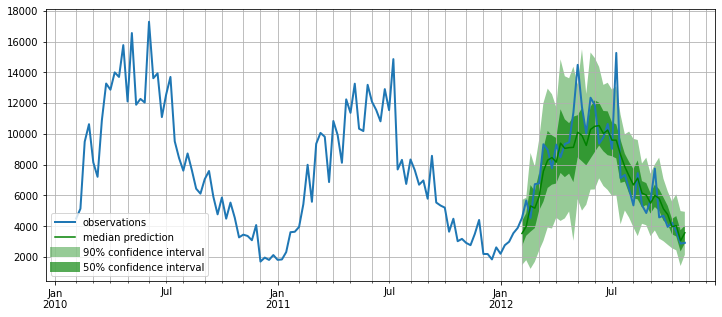

In [296]:
plot_forecasts(tss, forecasts, past_length=150,num_plots=5)

We can also evaluate the quality of our forecasts. GluonTS comes with an `Evaluator` that returns aggregate error metrics as well as metrics per time series which can be used e.g., for scatter plots.

In [297]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.5])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 209.94it/s]


In [300]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 23728796.411454547,
    "abs_error": 10600667.843712807,
    "abs_target_sum": 59572549.04000001,
    "abs_target_mean": 15275.012574358983,
    "seasonal_error": 2159.0943805825254,
    "MASE": 1.229462024190214,
    "sMAPE": 0.25488672017305225,
    "MSIS": 49.17848096760853,
    "QuantileLoss[0.5]": 10600667.843712807,
    "Coverage[0.5]": 0.2797435897435894,
    "RMSE": 4871.221244354905,
    "NRMSE": 0.3189012919394815,
    "ND": 0.17794551373980969,
    "wQuantileLoss[0.5]": 0.17794551373980969,
    "mean_wQuantileLoss": 0.17794551373980969,
    "MAE_Coverage": 0.22025641025641057
}


In [301]:
item_metrics.head()

,Coverage[0.5],MASE,MSE,MSIS,QuantileLoss[0.5],abs_error,abs_target_mean,abs_target_sum,item_id,sMAPE,seasonal_error
0,0.410256,0.838081,1.221856e+07,33.523229,111505.907617,111505.907617,34547.540769,1347354.09,NaN,0.095132,3411.516019
1,0.307692,1.343819,3.909187e+07,53.752779,182990.083555,182990.083555,33561.827949,1308911.29,NaN,0.143617,3491.580194
2,0.128205,1.382428,4.621251e+06,55.297124,64919.643125,64919.643125,8499.987949,331499.53,NaN,0.209736,1204.117767
3,0.205128,1.222270,1.312855e+07,48.890802,114254.118105,114254.118105,17953.562308,700188.93,NaN,0.172951,2396.845728
4,0.461538,0.791752,2.491158e+06,31.670088,44741.556895,44741.556895,7722.143590,301163.60,NaN,0.150597,1448.962718


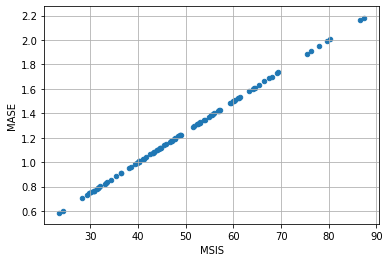

In [302]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

### DeepAR Estimator
For this example, use the DeepAREstimator, which implements the DeepAR model proposed in the DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks paper. Given one or more time series, the model is trained to predict the next prediction_length values given the preceding context_length values. Instead of predicting single best values for each position in the prediction range, the model parametrizes a parametric probability distribution for each output position.

To encapsulate models and trained model artifacts, GluonTS uses an Estimator/Predictor pair of abstractions that should be familiar to users of other machine learning frameworks. An Estimator represents a model that can be trained on a dataset to yield a Predictor, which can later be used to make predictions on unseen data.

Instantiate a DeepAREstimator object by providing a few hyperparameters:

* The time series frequency (for this example, I use 5 minutes, so freq="5min")
* The prediction length (36 time points, which makes it span 3 hours)

In [2]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
import pandas as pd
import matplotlib.pyplot as plt

In [238]:
train_data = train_ds
test_data = test_ds

In [240]:
estimator = DeepAREstimator(freq="W", 
                            prediction_length=39, 
                            trainer=Trainer(epochs=10),
                            num_layers=2,
                            num_cells=40)

In [241]:
predictor = estimator.train(training_data=train_data)

INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  8.21it/s, avg_epoch_loss=9.75]
INFO:root:Epoch[0] Elapsed time 6.094 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=9.748984
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:07<00:00,  6.48it/s, avg_epoch_loss=9.1]
INFO:root:Epoch[1] Elapsed time 7.724 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=9.101053
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:07<00:00,  6.54it/s, avg_epoch_loss=8.95]
INFO:root:Epoch[2] Elapsed time 7.648 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.945990
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:08<00:00,  6.17it/s, avg_epoch_loss=8.91]
INFO:root:Epoch[3] Elapsed time 8.113 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=8.912684
INFO:root:Epoch[4] Learning rate is 0.001
1

In [242]:
from itertools import islice
from gluonts.evaluation.backtest import make_evaluation_predictions

def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_eval_samples=200)
forecasts = list(forecast_it)
tss = list(ts_it)

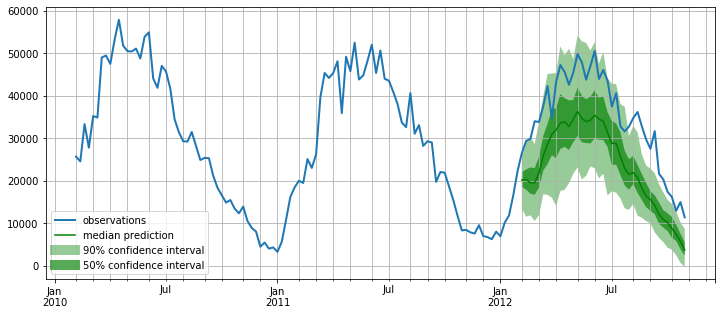

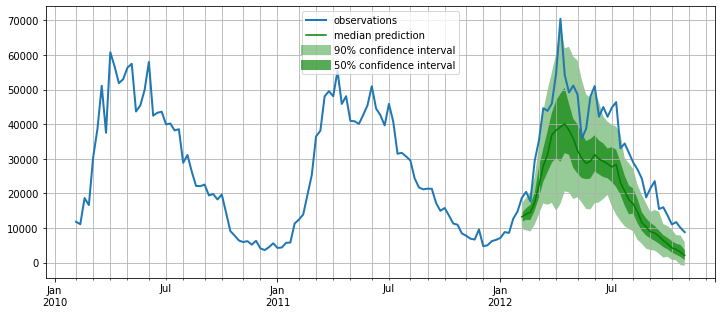

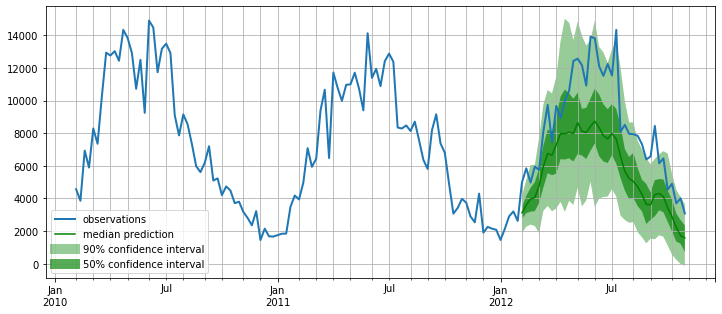

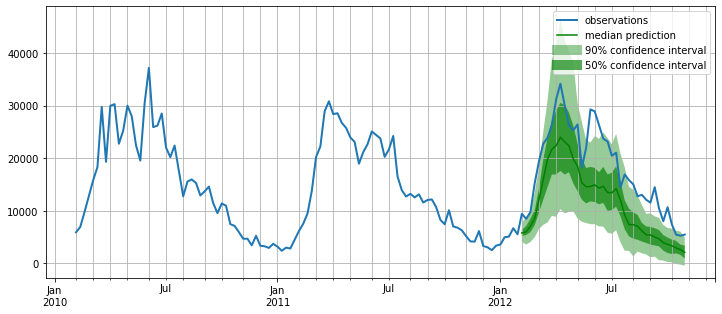

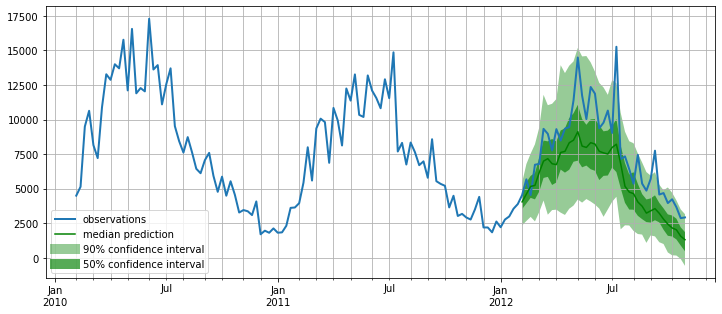

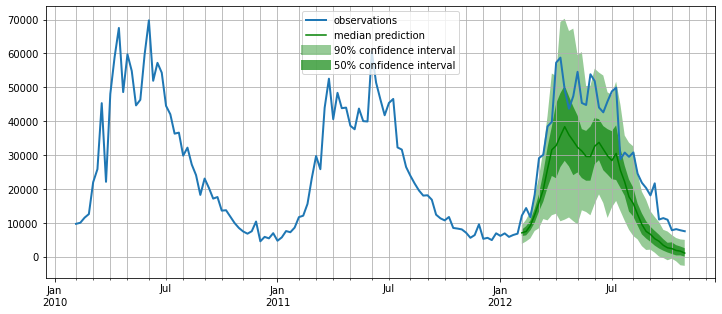

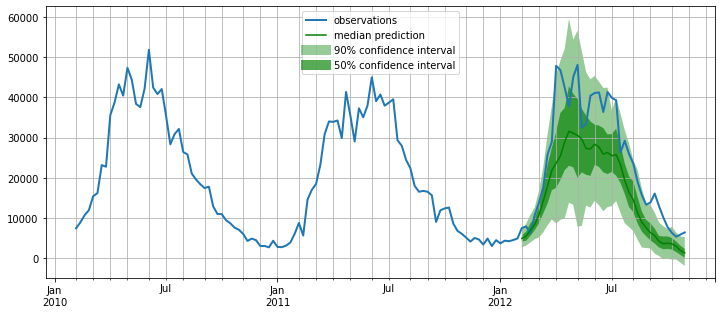

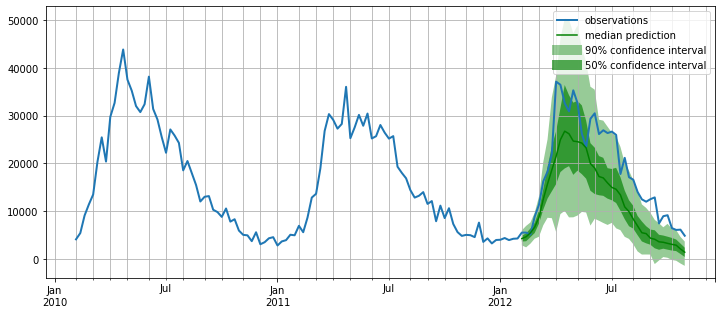

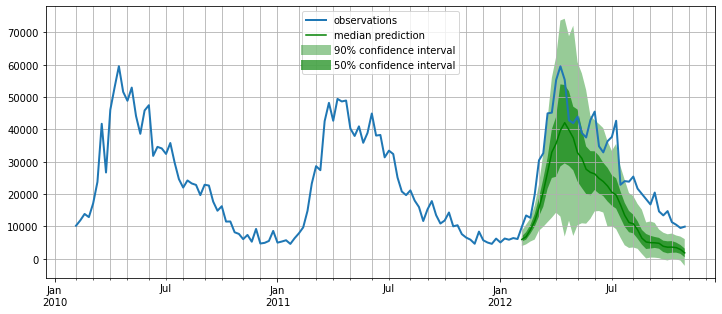

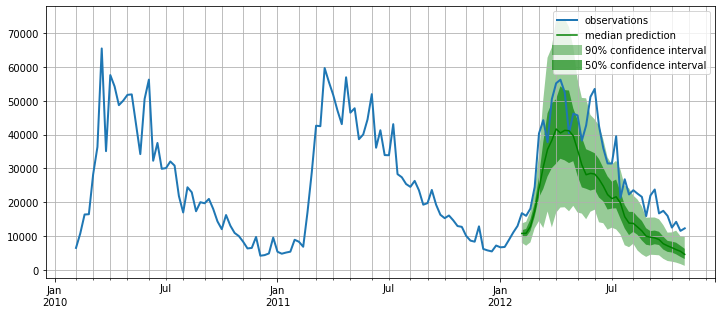

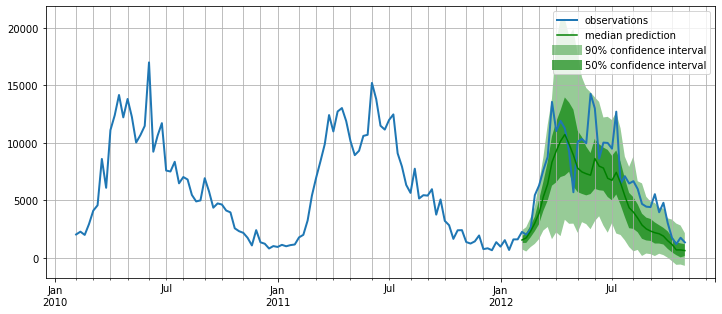

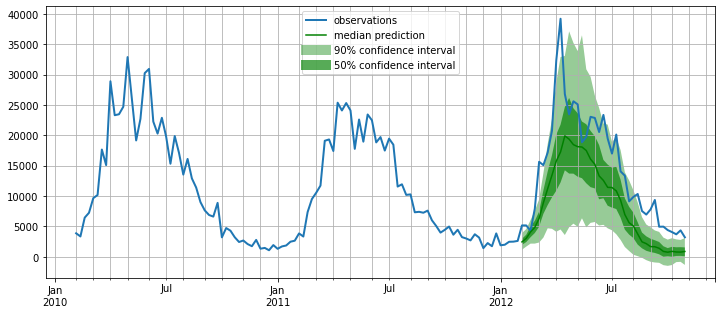

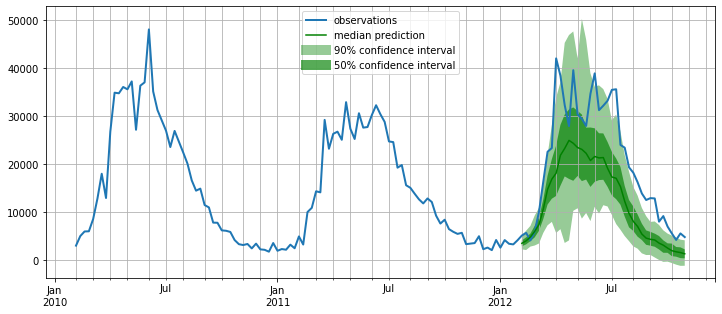

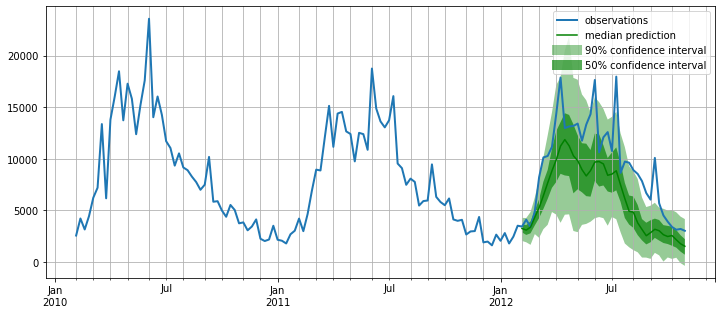

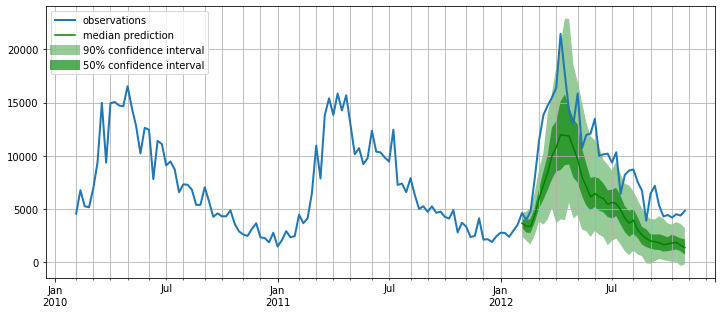

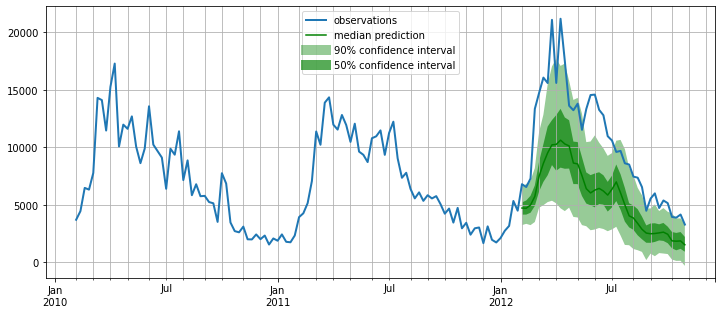

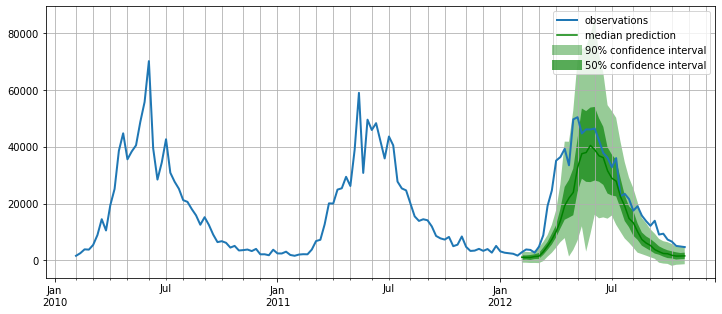

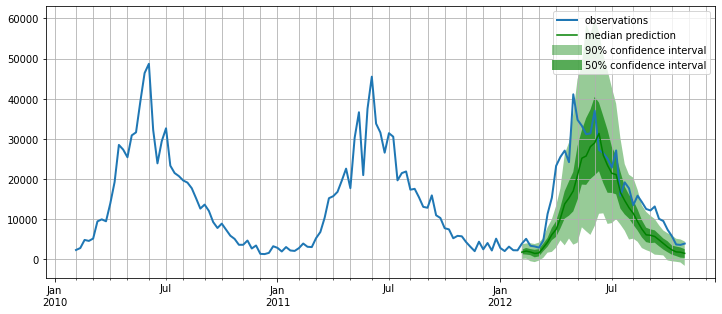

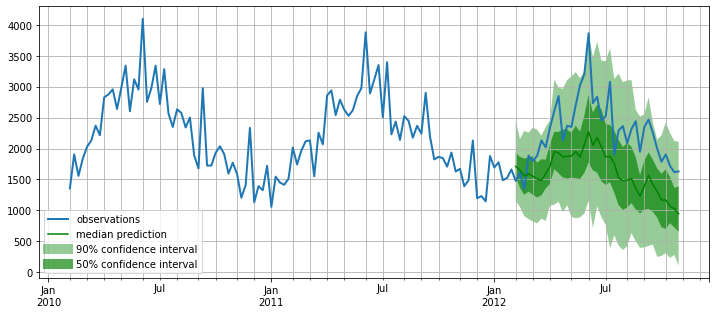

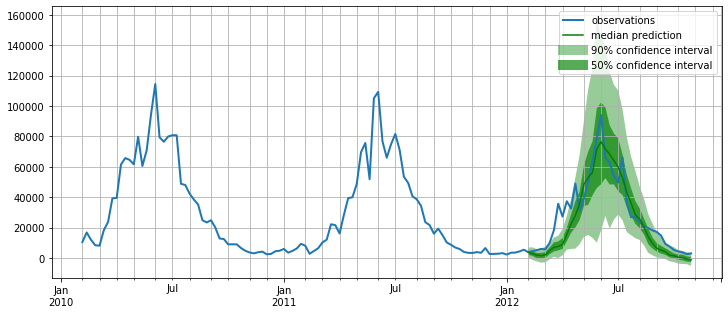

In [250]:
plot_forecasts(tss, forecasts, past_length=150,num_plots=20)

In [244]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.5])

agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 159.70it/s]


In [245]:
agg_metrics

{'MSE': 66606684.44227021,
 'abs_error': 20570723.496194277,
 'abs_target_sum': 59572549.04000001,
 'abs_target_mean': 15275.012574358983,
 'seasonal_error': 2159.0943805825254,
 'MASE': 2.294780003247541,
 'sMAPE': 0.4914094957693996,
 'MSIS': 91.7912001299017,
 'QuantileLoss[0.5]': 20570723.496194277,
 'Coverage[0.5]': 0.06999999999999998,
 'RMSE': 8161.291836607132,
 'NRMSE': 0.5342903514401605,
 'ND': 0.3453054104228788,
 'wQuantileLoss[0.5]': 0.3453054104228788,
 'mean_wQuantileLoss': 0.3453054104228788,
 'MAE_Coverage': 0.43000000000000005}

In [251]:
from gluonts.model.seasonal_naive import SeasonalNaivePredictor

seasonal_predictor_1W = SeasonalNaivePredictor(freq="W", prediction_length=39)

forecast_it, ts_it = make_evaluation_predictions(test_data,predictor=seasonal_predictor_1W, num_eval_samples=100)
forecasts_naive = list(forecast_it)
tss_naive = list(ts_it)

agg_metrics_seasonal, item_metrics_seasonal = evaluator(iter(tss_naive), iter(forecasts_naive), num_series=len(test_data))

Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 220.48it/s]


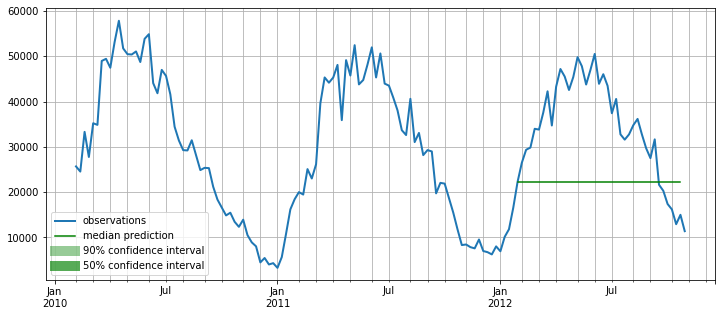

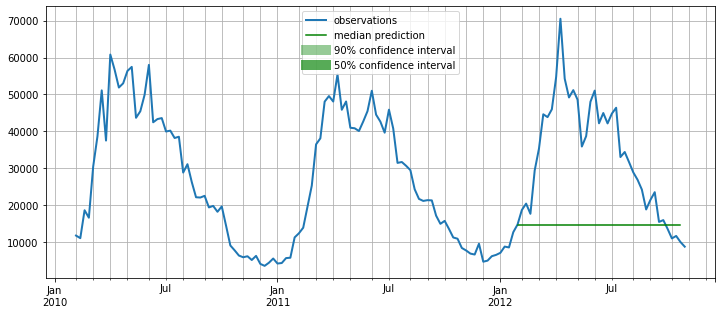

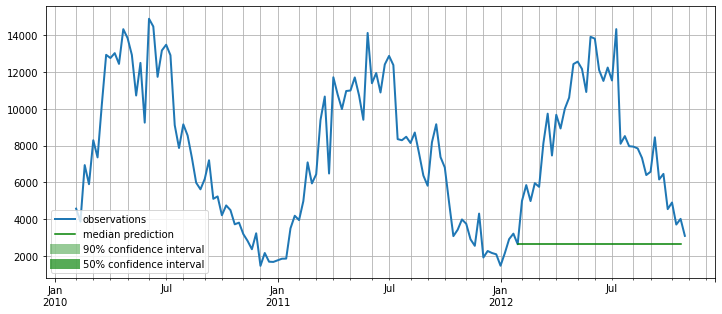

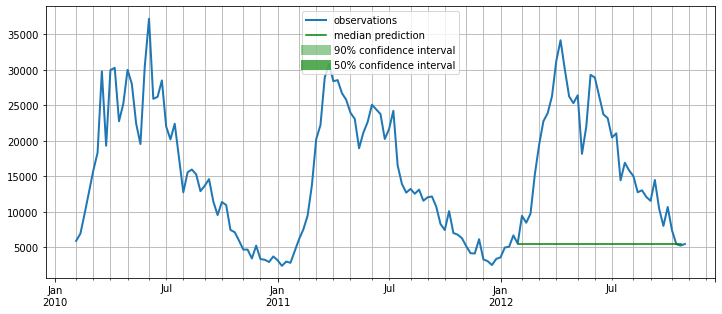

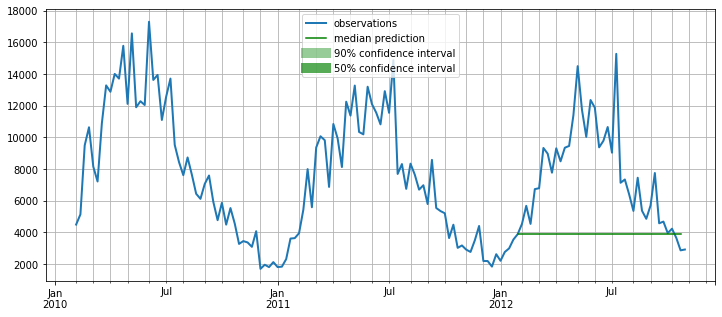

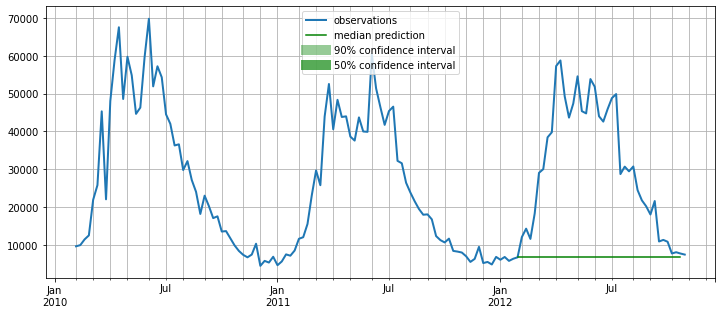

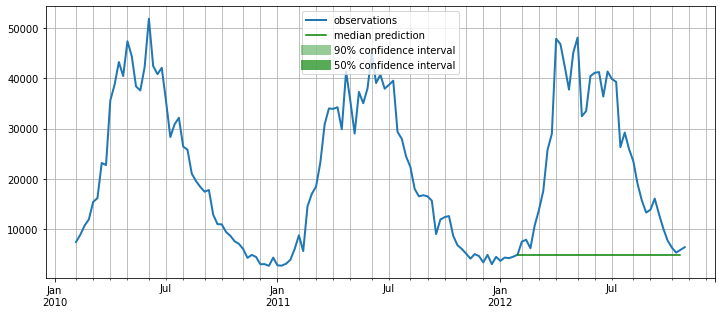

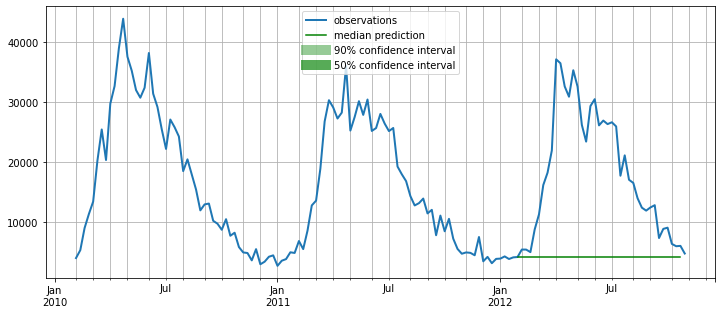

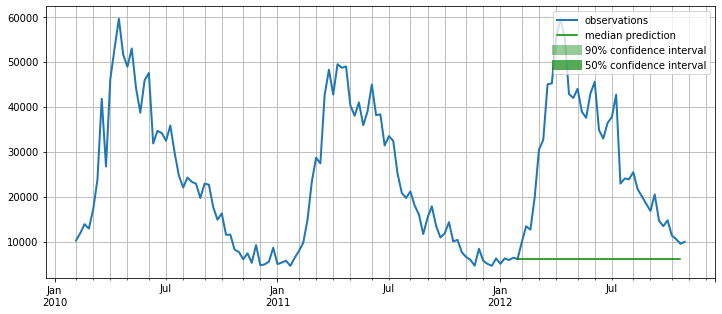

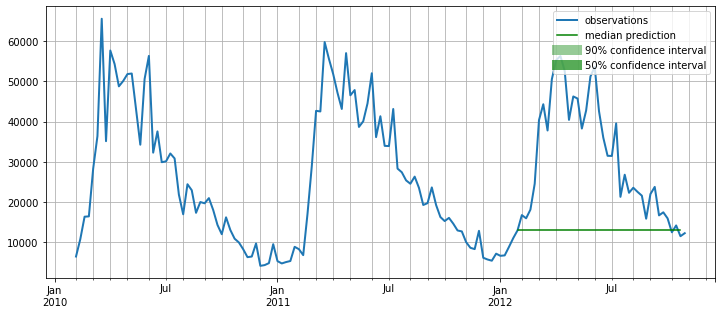

In [247]:
plot_forecasts(tss_naive, forecasts_naive, past_length=150,num_plots=10)

In [248]:
agg_metrics_seasonal

{'MSE': 193656507.81022853,
 'abs_error': 31073687.30827087,
 'abs_target_sum': 59515377.3,
 'abs_target_mean': 15260.353153846154,
 'seasonal_error': 2172.391566666666,
 'MASE': 3.4328953308608567,
 'sMAPE': 0.8133692856254794,
 'MSIS': 137.31581323443427,
 'QuantileLoss[0.5]': 31073687.30827087,
 'Coverage[0.5]': 0.07846153846153842,
 'RMSE': 13916.052163247612,
 'NRMSE': 0.911908919993786,
 'ND': 0.5221119098621739,
 'wQuantileLoss[0.5]': 0.5221119098621739,
 'mean_wQuantileLoss': 0.5221119098621739,
 'MAE_Coverage': 0.4215384615384616}

In [249]:
df_metrics = pd.DataFrame.join(
    pd.DataFrame.from_dict(agg_metrics, orient='index').rename(columns={0: "DeepAR"}),
    pd.DataFrame.from_dict(agg_metrics_seasonal, orient='index').rename(columns={0: "Seasonal naive"})
)
df_metrics.loc[["MASE", "sMAPE", "RMSE"]]

,DeepAR,Seasonal naive
MASE,2.294780,3.432895
sMAPE,0.491409,0.813369
RMSE,8161.291837,13916.052163


## Using Keras to Build Recursive Nerual Networks (RNN)

### Load Data

In [ ]:
ts = pd.read_csv('../data/sales_weekly.csv', index_col='ds')

In [ ]:
ts.head(5)

In [ ]:
ts['ds'] = ts.index
ts['ds'] = pd.to_datetime(ts['ds'])
ts = ts.set_index('ds')

#### Pick one store as an example (store "10_10")

In [ ]:
retail = ts.iloc[:,[1]]
retail = retail.rename(index=str, columns={'10_10':'sales'})

retail.index = pd.to_datetime(retail.index)
retail.index.freq = 'W-Fri'
retail.index

retail.iloc[-39,:]

#### Split the data into training and validaiton (39 week period)

In [ ]:
val_start_dt = '2012-02-03 00:00:00'

In [ ]:
retail[retail.index < val_start_dt][['sales']].rename(columns={'sales':'train'})\
    .join(retail[retail.index >= val_start_dt][['sales']].rename(columns={'sales':'test'}), how='outer')\
    .plot(y=['train','test'], figsize=(16,8), fontsize=10)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('sales', fontsize=12)
plt.show()

### Prepare Training Data

In [ ]:
# 1. Get the train data from the correct data range
train_ds = retail.copy()[retail.index < val_start_dt][['sales']]

In [ ]:
# 2. Scale data to be in range (0, 1). 
#   This transformation should be calibrated on the training set only. 
#   This is to prevent information from the validation or test sets 
#   leaking into the training data.
scaler = MinMaxScaler()
train_ds['sales'] = scaler.fit_transform(train_ds)

In [ ]:
# 3. Shift the dataframe to create the input samples.
# For this example, we will set T=6. 
# This means that the input for each sample is a vector of the prevous 6 weeks. 
# The choice of T=6 was arbitrary but should be selected through experimentation.
# HORIZON=1* specifies that we have a forecasting horizon of 1 (*t+1*)
T = 6
HORIZON = 1

train_shifted = train_ds.copy()
train_shifted['y_t+1'] = train_shifted['sales'].shift(-1, freq='W-FRI')
for t in range(1, T+1):
    train_shifted[str(T-t)] = train_shifted['sales'].shift(T-t, freq='W-FRI')
y_col = 'y_t+1'
X_cols = ['sales_t-5',
             'sales_t-4',
             'sales_t-3',
             'sales_t-2',
             'sales_t-1',
             'sales_t']
train_shifted.columns = ['sales_original']+[y_col]+X_cols

In [ ]:
train_shifted.describe()

In [ ]:
# 4.Discard any samples with missing values
train_shifted = train_shifted.dropna(how='any')
train_shifted.describe()

In [ ]:
# Now convert the target and input features into numpy arrays. 
# X needs to be in the **shape (samples, time steps, features)**. 
# Here we have 98 samples, 6 time steps and 1 feature (sales).

# 5.Transform this Pandas dataframe into a numpy array
y_train = train_shifted[y_col].values
X_train = train_shifted[X_cols].values

# This is an important step to reshape the X into 3 dimension array
X_train = X_train.reshape(X_train.shape[0], T, 1)

In [ ]:
y_train.shape

In [ ]:
y_train[:3]

In [ ]:
X_train.shape

In [ ]:
X_train[:3]

In [ ]:
train_shifted.head(3)

### Prepare Validation Data

In [ ]:
# 1. Get the validation data from the correct data range
look_back_dt = dt.datetime.strptime(val_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(weeks=T-1)
valid_ds = retail.copy()[retail.index >=look_back_dt][['sales']]

In [ ]:
# 2. Scale the series using the transformer fitted on the training set:
valid_ds['sales'] = scaler.transform(valid_ds)

In [ ]:
# 3. Shift the dataframe to create the input samples
valid_shifted = valid_ds.copy()
valid_shifted['y+1'] = valid_shifted['sales'].shift(-1, freq='W-FRI')
for t in range(1, T+1):
    valid_shifted['sales_t-'+str(T-t)] = valid_shifted['sales'].shift(T-t, freq='W-FRI')

In [ ]:
# 4.Discard any samples with missing values
valid_shifted = valid_shifted.dropna(how='any')
valid_shifted.head(3)

In [ ]:
# 5.Transform this Pandas dataframe into a numpy array
y_valid = valid_shifted['y+1'].values
X_valid = valid_shifted[['sales_t-'+str(T-t) for t in range(1, T+1)]].values
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

In [ ]:
y_valid.shape

In [ ]:
X_valid.shape

### Implement the RNN

In [ ]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

In [ ]:
LATENT_DIM = 5 # number of units in the RNN layer
BATCH_SIZE = 32 # number of samples per mini-batch
EPOCHS = 20 # maximum number of times the training algorithm will cycle through all samples

In [ ]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))

In [ ]:
model.compile(optimizer='RMSprop', loss='mse')

In [ ]:
model.summary()

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [ ]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

In [ ]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

# Recent development on DL

# Summary

## Comparison of Various Algorithms